In [1]:
pip install newspaper3k

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jpype1

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
from newspaper import Article
from konlpy.tag import Kkma
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
class SentenceTokenizer(object):
    def __init__(self):
        self.kkma = Kkma()
        self.Okt = Okt()
        self.stopwords = ['중인' ,'만큼', '마찬가지', '꼬집었', "연합뉴스", "데일리", "동아일보", "중앙일보", "조선일보", "기자"
,"아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",]
    def url2sentences(self, url):
        article = Article(url, language='ko')
        article.download()
        article.parse()
        sentences = self.kkma.sentences(article.text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences
    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences
    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence is not '':
                nouns.append(' '.join([nouns for nouns in self.Okt.nouns(str(sentence))
                                       if nouns not in self.stopwords and len(nouns) > 1]))
        return nouns
        

In [8]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

In [9]:
class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

In [10]:
class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        if text[:5] in ('http:', 'https'):
            self.sentences = self.sent_tokenize.url2sentences(text)
        else:
            self.sentences = self.sent_tokenize.text2sentences(text)
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)
    def summarize(self, sent_num=1):
        summary = []
        index=[]
        for idx in self.sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
        index.sort()
        for idx in index:
            summary.append(self.sentences[idx])
        return summary
    def keywords(self, word_num=5):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        return keywords

In [88]:
from PIL import Image
def draw_wordcloud(url): 
        news_text =''
        article = Article(url, language='ko')
        article.download()
        article.parse()
        article.text
        news_text = article.text
    
        engine = Okt() 
        nouns1 = engine.nouns(news_text)
        nouns1 = [n for n in nouns1 if len(n) > 1]

        # Counter: 단어수 세기, 가장 많이 등장한 단어(명사) 40개
        count = Counter(nouns1)
        tags = count.most_common(100)
        
        # 워드 클라우드 배경 사진
        book_mask = np.array(Image.open('1.png'))

        # WordCloud, matplotlib: 단어 구름 그리기
        font_path = 'E:\TextRank\KBLZ.ttf'
        wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600, mask=book_mask)
        cloud = wc.generate_from_frequencies(dict(tags))
        plt.figure(figsize=(10,8))
        plt.axis('off')
        plt.imshow(cloud)

이에 앞서 구는 지난 4 월 카 이스트 소프트웨어교육센터와 '4 차 산업혁명시대, 서초 미래 인재 양성을 위한 업무 협약' 을 맺고 6월부터 '4 차 산업 서초 청년 취업 스쿨' 을 진행하고 있다.

keywords : ['청년', '진행', '취업', '이스트', '산업']


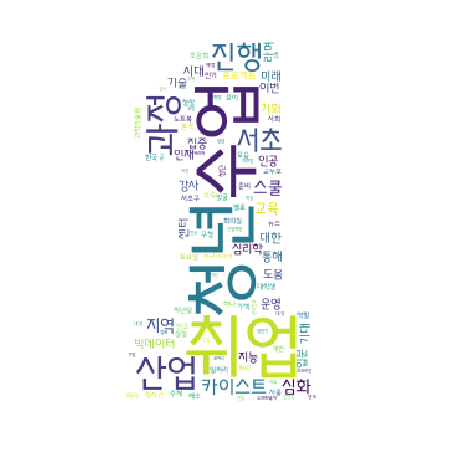

In [89]:
url = 'http://news1.kr/articles/?3710776'
textrank = TextRank(url)
for row in textrank.summarize(1):
    print(row)
    print()
print('keywords :',textrank.keywords())
draw_wordcloud(url)